In [9]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdchem import RWMol
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
from PIL import Image, ImageOps
IPythonConsole.ipython_useSVG = True
from io import BytesIO
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

import math
import pickle

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# interpret

In [6]:
# from heterogeneous graph to homogeneous graph
# define a method for 36 atom features 
def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        from rdkit import Chem
        results = one_of_k_encoding_unk(
          atom.GetSymbol(),
          [
            'C', 
            'N',
            'O',
            'S',
            'F', 
            'P',
            'Cl',
            'Br',
            'Unknown'
              ]) + one_of_k_encoding_unk(atom.GetDegree(),
                             [1, 2, 3, 4, 5, 6, 'Max']) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
        
        try:
            results = results + one_of_k_encoding_unk(
                atom.GetProp('_CIPCode'),
                ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                                ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)

def mol2feat(mol):
    atoms = mol.GetAtoms()
    res = np.zeros((45, 36)) # Set it
    for i,atom in enumerate(atoms):
        node_f = atom_features(atom)
        res[i,:] = node_f
    return res
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
# define molecule convert to graph method: predefine 4 type and 45*45 matrix
def mol2graph(mol):
    out = np.zeros((4, 45, 45))
    mol = mol_with_atom_index(mol)
    # core use MurckoScaffold
    core = MurckoScaffold.GetScaffoldForMol(mol)
    # find both side atom of bond (put them into different types)    
    for bond in mol.GetBonds():
        typ = str(bond.GetBondType())
        begin_atom = bond.GetBeginAtom()
        end_atom = bond.GetEndAtom()
        begin_smb = bond.GetBeginAtom().GetSymbol()
        end_smb = bond.GetEndAtom().GetSymbol()
        begin = int(begin_atom.GetProp('molAtomMapNumber'))
        end = int(end_atom.GetProp('molAtomMapNumber'))
        # here is the second type: all atom type
        out[1, begin, end] = 1
        out[1, end, begin] = 1
        # here is the thrid type: aromatic ring type        
        if typ == "AROMATIC":  
            out[2, begin, end] = 1
            out[2, end, begin] = 1
        # here is the fourth type: heteroatom type         
        if (begin_smb == 'C' and end_smb in ('N','O','S')) or (begin_smb in ('N','O','S') and end_smb == 'C'):
            out[3, begin, end] = 1
            out[3, end, begin] = 1
            # here is the first type: scaffold core structure type  
    # core index needs to keep the same index with all atom index
    for bond in core.GetBonds(): 
        typ = str(bond.GetBondType())
        begin_atom = bond.GetBeginAtom()
        end_atom = bond.GetEndAtom()
        begin = int(begin_atom.GetProp('molAtomMapNumber'))
        end = int(end_atom.GetProp('molAtomMapNumber'))
        
        out[0, begin, end] = 1
        out[0, end, begin] = 1
        
    return out
class GTConv(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(GTConv, self).__init__()     
        self.in_channels = in_channels
        self.out_channels = out_channels
        # define a learnable weight
        self.weight = nn.Parameter(torch.Tensor(out_channels,in_channels,1,1))
        self.bias = None
        self.scale = nn.Parameter(torch.Tensor([0.1]), requires_grad=False)
        self.reset_parameters()
    
    def reset_parameters(self):
        n = self.in_channels
        nn.init.constant_(self.weight, 0.1)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    # calculate A * weight: sum function could be changed by any function such as max().
    def forward(self, A):
        Q = torch.sum(A * F.softmax(self.weight, dim=1), dim=1)
        return Q

class GTLayer(nn.Module):    
    def __init__(self, in_channels, out_channels, first=True):
        super(GTLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.first = first
        if self.first == True:
            self.conv1 = GTConv(in_channels, out_channels)
            self.conv2 = GTConv(in_channels, out_channels)
        else:
            self.conv1 = GTConv(in_channels, out_channels)
    
    def forward(self, A, A_p_=None):
        if self.first == True:
            Q_1 = self.conv1(A)
            Q_2 = self.conv2(A)
            A_p = torch.bmm(Q_1, Q_2)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach(), (F.softmax(self.conv2.weight, dim=1)).detach()]
        else:
            Q = self.conv1(A)
            A_p = torch.bmm(A_p_, Q)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach()]
        return A_p, W, Q_1, Q_2

class GTN(nn.Module):    
    def __init__(self, num_edge, num_channels, w_in, w_out, num_class, num_layers, norm):
        super(GTN, self).__init__()
        self.num_edge = num_edge
        self.num_channels = num_channels
        self.w_in = w_in
        self.w_out = w_out
        self.num_class = num_class
        self.num_layers = num_layers
        self.is_norm = norm
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(GTLayer(num_edge, num_channels, first=True))
            else:
                layers.append(GTLayer(num_edge, num_channels, first=False))
        self.layers = nn.ModuleList(layers)
        self.weight = nn.Parameter(torch.Tensor(w_in, w_out))
        self.bias = nn.Parameter(torch.Tensor(w_out))
        self.loss = nn.CrossEntropyLoss()
        self.linear1 = nn.Linear(self.w_out*self.num_channels, self.w_out)
        self.linear2 = nn.Linear(self.w_out, self.num_class)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def gcn_conv(self, N_f, A_p):
        N_f = torch.mm(N_f, self.weight)
        A_p = self.norm(A_p, add=True)
        return torch.mm(A_p.t(), N_f)
    
    def normalization(self, A_p):
        for i in range(self.num_channels):
            if i==0:
                A_p_ = self.norm(A_p[i,:,:]).unsqueeze(0)
            else:
                A_p_ = torch.cat((A_p_,self.norm(A_p[i,:,:]).unsqueeze(0)), dim=0)
        return A_p_

    def norm(self, A_p, add=False):
        A_p = A_p.t()
        if add == False:
            A_p = A_p*((torch.eye(A_p.shape[0])==0).type(torch.FloatTensor))
        else:
            A_p = A_p*((torch.eye(A_p.shape[0])==0).type(torch.FloatTensor)) + torch.eye(A_p.shape[0]).type(torch.FloatTensor)
        deg = torch.sum(A_p, dim=1)
        deg_inv = deg.pow(-1)
        deg_inv[deg_inv == float('inf')] = 0
        deg_inv = deg_inv*torch.eye(A_p.shape[0]).type(torch.FloatTensor)
        A_p = torch.mm(deg_inv, A_p)
        A_p = A_p.t()
        return A_p

    def forward(self, A, N_f): # A use for making meta-path
        A = A.unsqueeze(0).permute(0,3,1,2) #(1,64,64,4) -> (1,4,64,64)
        Ws = []
        leakyrelu = nn.LeakyReLU(0.1)
        for i in range(self.num_layers):
            if i == 0:
                A_p, W, Q_1, Q_2 = self.layers[i](A) # H shape, torch.Size([chnnel, 64, 64])
            else:
                A_p = self.normalization(A_p)
                A_p, W = self.layers[i](A, A_p)
            Ws.append(W)
        

        for i in range(self.num_channels): # N_f and A_p use for general GCN
            if i==0:
                N_f_ = F.relu(self.gcn_conv(N_f,A_p[i])) # N_f: features, A_p: meta-path
            else:
                N_f_tmp = F.relu(self.gcn_conv(N_f,A_p[i]))
                N_f_ = torch.cat((N_f_,N_f_tmp), dim=1)

        N_f_ = torch.sum(N_f_, 0) #(45,36) -> (36,)
        N_f_ = self.linear1(N_f_) #(36,) -> (16,)
        N_f_ = leakyrelu(N_f_)
        N_f_ = self.linear2(N_f_) #(16,) -> (2)
        y = N_f_.unsqueeze(0)
        
        return y, Ws, A_p, Q_1, Q_2

torch.Size([45, 45, 4])
torch.Size([45, 36])
[[tensor([[[[0.0865]],

         [[0.3513]],

         [[0.0742]],

         [[0.4880]]]]), tensor([[[[0.2668]],

         [[0.5194]],

         [[0.1563]],

         [[0.0575]]]])]]
The 0 Mol:



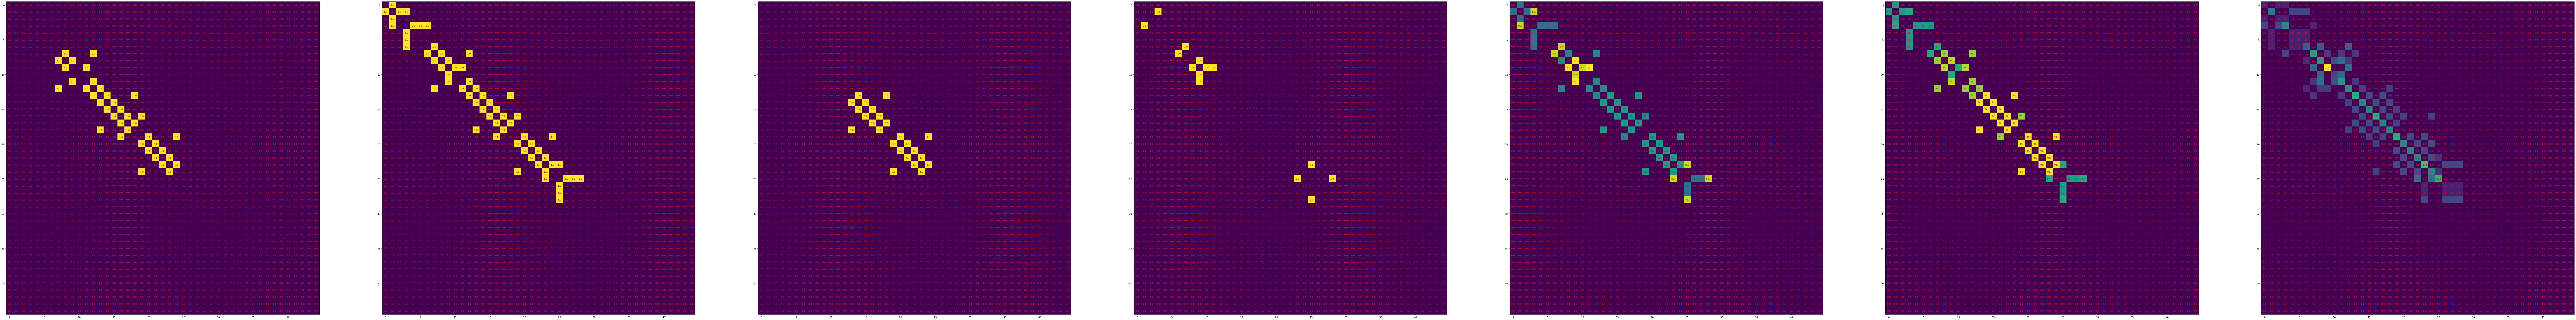

In [7]:
# Input only one mol:
ckeckmol = Chem.MolFromSmiles('CC(C)S(=O)(=O)N[C@H]1CN(C)C[C@@H]1c2ccc(cc2)c3cccc(c3)S(=O)(=O)C')
DEVICE = torch.device("cpu")
model = GTN(num_edge=4, # num of edge types: 
            num_channels=1, 
            w_in = 36, # node_features
            w_out = 64, # we just define it
            num_class = 2, # 4
            num_layers= 1, # how many GTLayers: 1
            norm='true').to(DEVICE)
model.load_state_dict(torch.load('Model/best_in_fold_9.pth'))

X = mol2feat(ckeckmol)
A = mol2graph(ckeckmol)

# plt.imshow(A[0,:])
A = np.transpose(A, (1,2,0))
tenA = torch.from_numpy(A).to(DEVICE)
tenX = torch.from_numpy(X).to(DEVICE)
tenA = tenA.type(torch.float)
tenX = tenX.type(torch.float)
print(tenA.shape)
print(tenX.shape)
# plt.imshow(tenA[0:45,0:45,0].detach().numpy())


Hs = []
a_s = []
b_s = []

# for batch_idx, (A, X, y) in enumerate(testloader):
#     A = A[0,:].to(DEVICE)
#     X = X[0,:].to(DEVICE)
pred, Ws, H, a, b = model(tenA, tenX)
Hs.append(H)
a_s.append(a)
b_s.append(b)

print(Ws)
for i in range(1):
    print("The",i, "Mol:"+"\n")
    fig = plt.figure(figsize=(200, 60))
    
    ax = fig.add_subplot(1,7,1)
    plt.imshow(tenA[:,:,0].numpy())
#     plt.title("A_Scaff:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,0].numpy()[x, y],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,2)
    plt.imshow(tenA[:,:,1].numpy())
#     plt.title("A_ALL:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,1].numpy()[x, y],
                       ha="center", va="center", color="r")

    
    ax = fig.add_subplot(1,7,3)
    plt.imshow(tenA[:,:,2].numpy())
#     plt.title("A_Aroma:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,2].numpy()[x, y],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,4)
    plt.imshow(tenA[:,:,3].numpy())
#     plt.title("A_NOS:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,3].numpy()[x, y],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,5)
    plt.imshow(a_s[i][0,:,:].detach().numpy())
#     plt.title("a:"+str(i))
    for x in range(45):
        for y in range(45):
            strr = str(100*a_s[i][0,:,:].detach().numpy()[x, y])
            text = ax.text(y, x, strr[0:3],
                       ha="center", va="center", color="r")
            
    ax = fig.add_subplot(1,7,6)
    plt.imshow(b_s[i][0,:,:].detach().numpy())
#     plt.title("b:"+str(i))
    for x in range(45):
        for y in range(45):
            strr = str(100*b_s[i][0,:,:].detach().numpy()[x, y])
            text = ax.text(y, x, strr[0:3],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,7)
    plt.imshow(Hs[i][0,:,:].detach().numpy())
#     plt.title("H:"+str(i))
    for x in range(45):
        for y in range(45):
            strr = str(100*Hs[i][0,:,:].detach().numpy()[x, y])
            text = ax.text(y, x, strr[0:3],
                       ha="center", va="center", color="r")
        

            
    plt.savefig('/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/diff4_1.png')

# Visualization

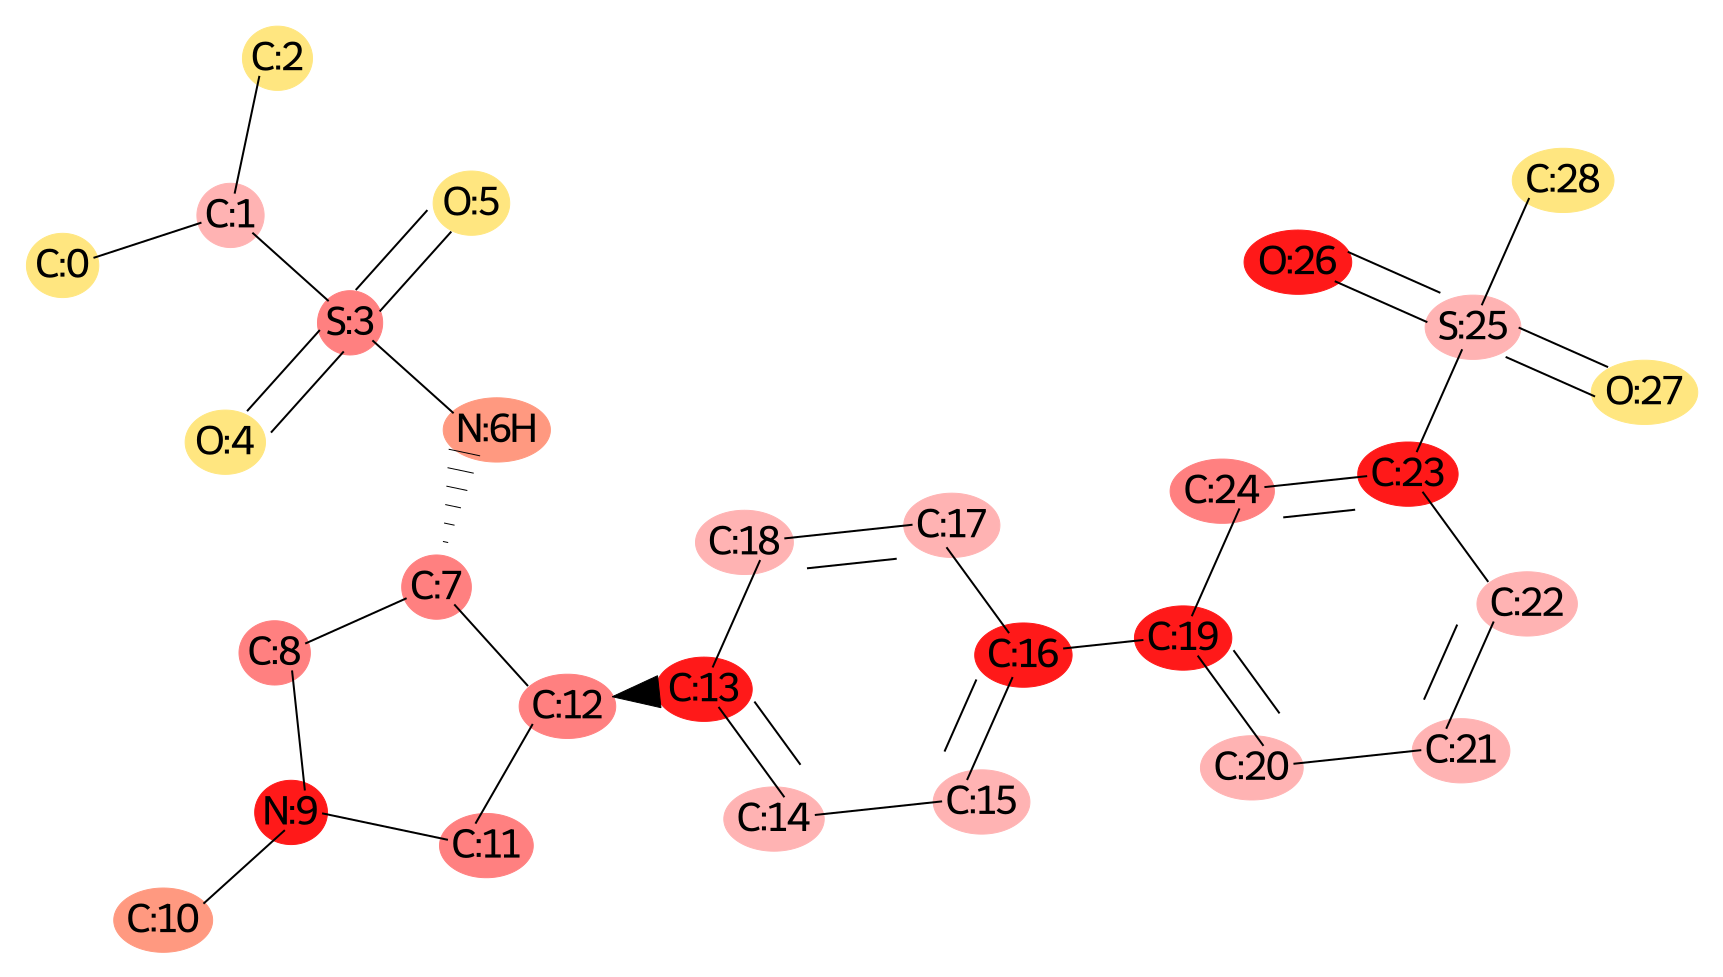

In [10]:
def _drawerToImage(d2d):
    try:
        import Image
    except ImportError:
        from PIL import Image
    sio = BytesIO(d2d.GetDrawingText())
    return Image.open(sio)

def clourMol(mol,highlightAtoms_p=None,highlightAtomColors_p=None,highlightBonds_p=None,highlightBondColors_p=None,sz=[2000,2000]):
    '''

    '''
    d2d = rdMolDraw2D.MolDraw2DCairo(sz[0], sz[1])
    op = d2d.drawOptions()
    op.dotsPerAngstrom = 5
    op.useBWAtomPalette()
    mc = rdMolDraw2D.PrepareMolForDrawing(mol)
    d2d.DrawMolecule(mc, legend='', highlightAtoms=highlightAtoms_p,highlightAtomColors=highlightAtomColors_p, highlightBonds= highlightBonds_p,highlightBondColors=highlightBondColors_p)
    d2d.FinishDrawing()
    product_img=_drawerToImage(d2d)
    return product_img
def StripAlphaFromImage(img):
    '''This function takes an RGBA PIL image and returns an RGB image'''

    if len(img.split()) == 3:
        return img
    return Image.merge('RGB', img.split()[:3])


def TrimImgByWhite(img, padding=20):
    '''This function takes a PIL image, img, and crops it to the minimum rectangle
    based on its whiteness/transparency. 5 pixel padding used automatically.'''

    # Convert to array
    as_array = np.array(img)  # N x N x (r,g,b,a)

    # Set previously-transparent pixels to white
    if as_array.shape[2] == 4:
        as_array[as_array[:, :, 3] == 0] = [255, 255, 255, 0]

    as_array = as_array[:, :, :3]

    # Content defined as non-white and non-transparent pixel
    has_content = np.sum(as_array, axis=2, dtype=np.uint32) != 255 * 3
    xs, ys = np.nonzero(has_content)

    # Crop down
    margin = 5
    x_range = max([min(xs) - margin, 0]), min([max(xs) + margin, as_array.shape[0]])
    y_range = max([min(ys) - margin, 0]), min([max(ys) + margin, as_array.shape[1]])
    as_array_cropped = as_array[
        x_range[0]:x_range[1], y_range[0]:y_range[1], 0:3]

    img = Image.fromarray(as_array_cropped, mode='RGB')

    return ImageOps.expand(img, border=padding, fill=(255, 255, 255))

def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

smi = Chem.MolFromSmiles('CC(C)S(=O)(=O)N[C@H]1CN(C)C[C@@H]1c2ccc(cc2)c3cccc(c3)S(=O)(=O)C')

mol =  mol_with_atom_index(smi)
img5 = clourMol(mol,highlightAtoms_p=[0,1,2,3,4,5,6,7,8,9,10,
                                      11,12,13,14,15,16,17,18,19,20,
                                      21,22,23,24,25,26,27,28],
                highlightAtomColors_p={0:(1,0.9,0.5),2:(1,0.9,0.5),4:(1,0.9,0.5),5:(1,0.9,0.5),28:(1,0.9,0.5),27:(1,0.9,0.5),
                                       10:(1,0.6,0.5),6:(1,0.6,0.5),
                                       1:(1,0.7,0.7),14:(1,0.7,0.7),15:(1,0.7,0.7),17:(1,0.7,0.7),18:(1,0.7,0.7),20:(1,0.7,0.7),21:(1,0.7,0.7),22:(1,0.7,0.7),25:(1,0.7,0.7),
                                       3:(1,0.5,0.5),7:(1,0.5,0.5),8:(1,0.5,0.5),11:(1,0.5,0.5),12:(1,0.5,0.5),
                                       9:(1,0.1,0.1),13:(1,0.1,0.1),16:(1,0.1,0.1),19:(1,0.1,0.1),23:(1,0.1,0.1),26:(1,0.1,0.1)})
img5 = TrimImgByWhite(img5)

# Draw.MolToFile(img5,'test.png',size=(300, 300))
# img = Draw.MolToImage(img5, size=(2000,2000))
display(img5)
img5.save('/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/int-mol4-1.png')